In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import heapq
from sklearn.datasets import make_blobs


In [4]:

X, Y = make_blobs(n_samples=100, centers=5, random_state=42, cluster_std=[0.5, 0.7, 0.9, 1.2, 1.5])
points = [(x,y) for x,y in X]

In [5]:
# points = [(1,9),(2,8),(1.5,7),(1,6),(2,6),(4,3),(5,3),(4,2),(5,5),(6,1)]
point_id = {point : idx for idx, point in enumerate(points)}

In [6]:
# implement k-d tree

In [7]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Point({self.x}, {self.y})"


In [8]:
class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right

class KDTree:
    def __init__(self):
        self.root = None

    def build(self, points, depth=0):
        if not points:
            return None
        
        k = len(points[0])  # Dimensionality of the data
        axis = depth % k

        # Sort points by the current axis and choose the median as the pivot
        points.sort(key=lambda x: x[axis])
        median = len(points) // 2

        return KDNode(
            point=points[median],
            axis=axis,
            left=self.build(points[:median], depth + 1),
            right=self.build(points[median + 1:], depth + 1)
        )

    def insert(self, point):
        def _insert_rec(node, point, depth=0):
            if node is None:
                k = len(point)
                return KDNode(point, depth % k)
            
            if point[node.axis] < node.point[node.axis]:
                node.left = _insert_rec(node.left, point, depth + 1)
            else:
                node.right = _insert_rec(node.right, point, depth + 1)
            
            return node

        self.root = _insert_rec(self.root, point)

# Example usage:



In [9]:
tree = KDTree()

tree.root = tree.build(points)



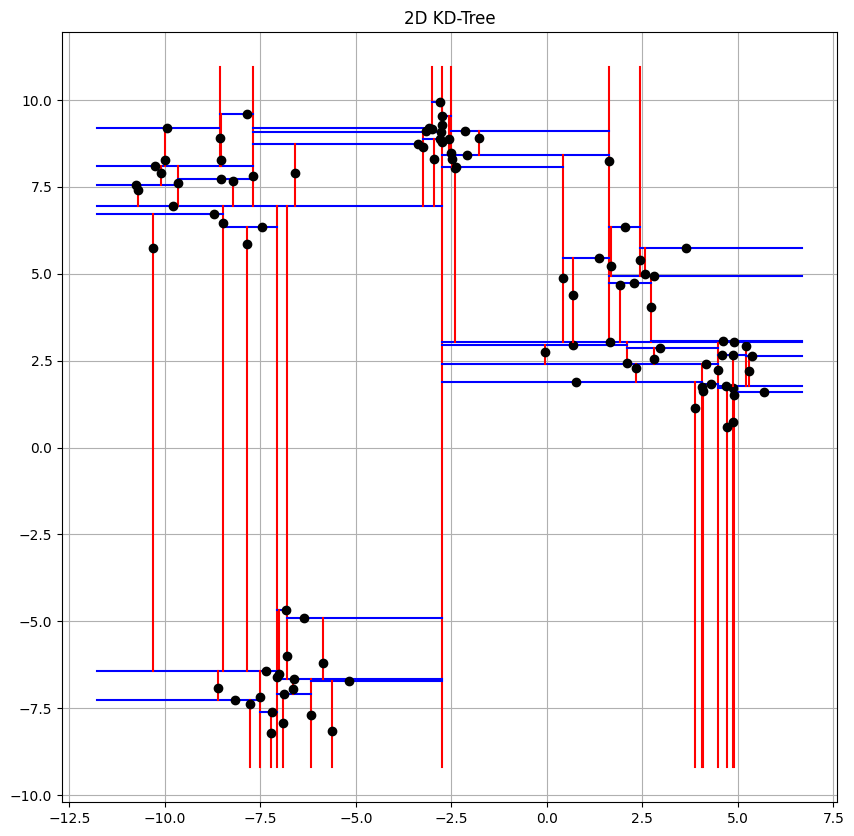

In [10]:

def plot_kd_tree(node, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    """Plot the kd-tree using matplotlib."""
    if node is None:
        return
    
    cur_point = node.point
    axis = node.axis

    if axis == 0:
        if branch is not None and prev_node is not None:
            if branch:
                max_y = prev_node.point[1]
            else:
                min_y = prev_node.point[1]
                
        plt.plot([cur_point[0], cur_point[0]], [min_y, max_y], 'r')
        plot_kd_tree(node.left, min_x, cur_point[0], min_y, max_y, node, True, depth + 1)
        plot_kd_tree(node.right, cur_point[0], max_x, min_y, max_y, node, False, depth + 1)

    elif axis == 1:
        if branch is not None and prev_node is not None:
            if branch:
                max_x = prev_node.point[0]
            else:
                min_x = prev_node.point[0]
                
        plt.plot([min_x, max_x], [cur_point[1], cur_point[1]], 'b')
        plot_kd_tree(node.left, min_x, max_x, min_y, cur_point[1], node, True, depth + 1)
        plot_kd_tree(node.right, min_x, max_x, cur_point[1], max_y, node, False, depth + 1)

    plt.plot(cur_point[0], cur_point[1], 'ko')

# Plotting
plt.figure(figsize=(10, 10))
plt.title("2D KD-Tree")
plot_kd_tree(tree.root, min_x=min([p[0] for p in points]) - 1, max_x=max([p[0] for p in points]) + 1,
             min_y=min([p[1] for p in points]) - 1, max_y=max([p[1] for p in points]) + 1, prev_node=None, branch=None)
plt.grid(True)
plt.show()

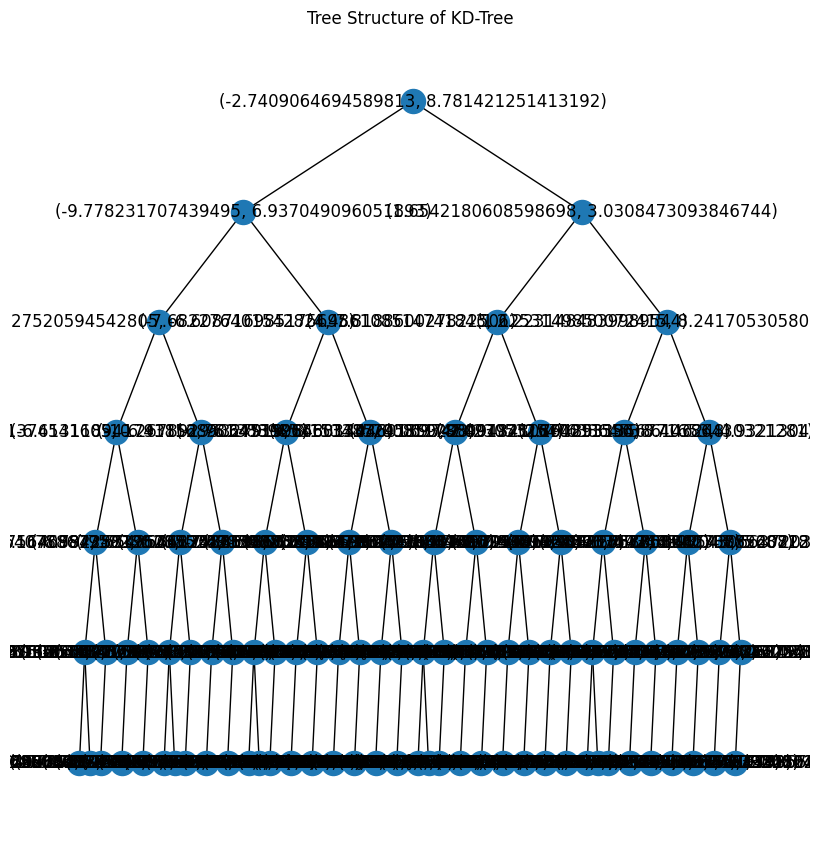

In [11]:
def add_nodes_edges(graph, node, pos={}, x=0, y=0, layer=1):
    """Recursively add nodes and edges to the graph."""
    pos[node.point] = (x, y)
    if node.left:
        graph.add_edge(node.point, node.left.point)
        l = x - 1 / 2 ** layer
        add_nodes_edges(graph, node.left, x=l, y=y - 1, pos=pos, layer=layer + 1)
    if node.right:
        graph.add_edge(node.point, node.right.point)
        r = x + 1 / 2 ** layer
        add_nodes_edges(graph, node.right, x=r, y=y - 1, pos=pos, layer=layer + 1)
    return graph, pos

def draw_tree(tree_root):
    """Draw the tree using networkx and matplotlib."""
    tree = nx.DiGraph()
    tree, pos = add_nodes_edges(tree, tree_root)
    nx.draw(tree, pos=pos, with_labels=True, arrows=False)
    
# Draw the tree structure
plt.figure(figsize=(8, 8))
draw_tree(tree.root)
plt.title("Tree Structure of KD-Tree")
plt.show()

In [12]:
def ith_nearest_neighbor(tree, query_point, i):
    """Find the ith nearest neighbor of the given point using a set to track visited nodes."""
    if tree.root is None:
        return None

    # Priority queue to maintain i nearest neighbors
    neighbors = []
    
    # Set to track visited nodes
    visited = set()

    def _search(node):
        if node is None or node in visited:
            return

        visited.add(node)

        # Calculate distance from the current node to the query point
        distance = sum([(a - b) ** 2 for a, b in zip(node.point, query_point)]) ** 0.5

        # If we have less than i neighbors, just add the current node
        if len(neighbors) < i:
            heapq.heappush(neighbors, (-distance, node.point))
        else:
            # If the current node is closer than the farthest neighbor, update the queue
            if distance < -neighbors[0][0]:
                heapq.heappop(neighbors)
                heapq.heappush(neighbors, (-distance, node.point))

        axis = node.axis
        next_branch = None
        opposite_branch = None

        if query_point[axis] < node.point[axis]:
            next_branch = node.left
            opposite_branch = node.right
        else:
            next_branch = node.right
            opposite_branch = node.left

        # Recursively search the half of the tree that contains the test point
        _search(next_branch)

        # If difference between splitting coordinate and test point's coordinate is
        # less than the distance from test point to the farthest neighbor, search the other half
        if (len(neighbors) < i or
                abs(query_point[axis] - node.point[axis]) < -neighbors[0][0]):
            _search(opposite_branch)

    _search(tree.root)

    # Return the i-th nearest neighbor
    return neighbors[0][1]

# Test the modified function
query_point = (1, 9)
ith_point_with_set = ith_nearest_neighbor(tree, query_point, 3)
ith_point_with_set


(2.041803072681036, 6.341752671656884)

In [13]:
k = 2
Nb = {pt:0 for pt in points}
# count num of 0s in Nb
NN = {pt:set() for pt in points}
RNN = {pt:set() for pt in points}
NaN = {pt:set() for pt in points}

while True:
    zeros_in_Nb = sum(1 for value in Nb.values() if value == 0)
    for pointi in points:
        pointj = ith_nearest_neighbor(tree, pointi, k)
        
        if pointj not in NN[pointi]:
            NN[pointi].add(pointj)
            RNN[pointj].add(pointi)
            Nb[pointj] += 1
        # print(Nb , NN , RNN) 
    new_zeros_in_Nb = sum(1 for value in Nb.values() if value == 0)
    if new_zeros_in_Nb == zeros_in_Nb:
        break
    k += 1
NaN = {pt : NNi.intersection(RNNi) for pt , NNi, RNNi in zip(points , NN.values(), RNN.values())}
print(NN )
print(RNN)
print(NaN)

{(-10.767307638109482, 7.5450835457374685): {(-10.113092213107336, 7.891833832260921), (-9.778231707439495, 6.937049096051893), (-10.26789195327919, 8.111387245859298), (-10.007945760908797, 8.268024439989645), (-10.699123873915369, 7.405798485265936), (-9.654357422530198, 7.602227352091908)}, (-10.699123873915369, 7.405798485265936): {(-10.113092213107336, 7.891833832260921), (-9.778231707439495, 6.937049096051893), (-10.767307638109482, 7.5450835457374685), (-10.26789195327919, 8.111387245859298), (-10.007945760908797, 8.268024439989645), (-9.654357422530198, 7.602227352091908)}, (-10.322668609689709, 5.738974979797572): {(-9.778231707439495, 6.937049096051893), (-8.486640788677592, 6.4663012138670615), (-10.767307638109482, 7.5450835457374685), (-8.718746118530841, 6.7193521305592645), (-10.699123873915369, 7.405798485265936), (-9.654357422530198, 7.602227352091908)}, (-10.26789195327919, 8.111387245859298): {(-10.113092213107336, 7.891833832260921), (-10.767307638109482, 7.54508354

In [14]:
def distance(point1, point2):
    return sum([(a - b) ** 2 for a, b in zip(point1, point2)]) ** 0.5

In [15]:
def plot_graph(neibours_set):
    G = nx.Graph()
    weight = 0
    edge_set = set()
    # Add nodes
    for point in neibours_set.keys():
        G.add_node(point)

    # Add edges based on the connections
    for pt in neibours_set.keys():
        for pt2 in neibours_set[pt]:
            G.add_edge(pt, pt2)
            edge_set.add((pt, pt2))
            weight += distance(pt, pt2)
            
  

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    plt.title(f"no of edges = {len(edge_set)} , weight = {round(weight , 2)}")
    nx.draw(G, pos, with_labels=0, node_size=70, node_color="lightblue", edge_color="gray")
    plt.show()







In [30]:
def matplot(neibours_set):
    plt.scatter(X[:, 0], X[:, 1],  cmap='viridis', s=10)
    

    # Add edges based on the connections
    for pt in neibours_set.keys():
        for pt2 in neibours_set[pt]:
            plt.plot( pt , pt2,  color='red', linestyle='--', linewidth=0.8)

/tmp/ipykernel_7953/1187556163.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1],  cmap='viridis', s=10)


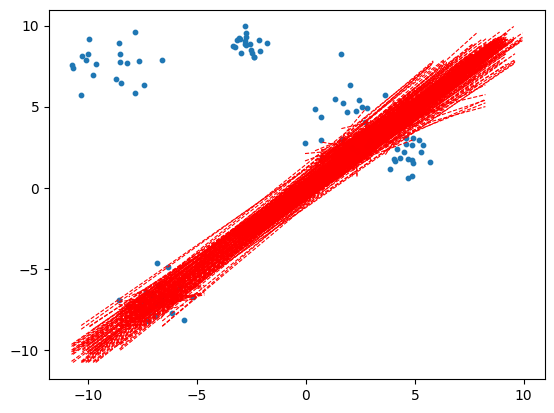

In [33]:
matplot(NN)

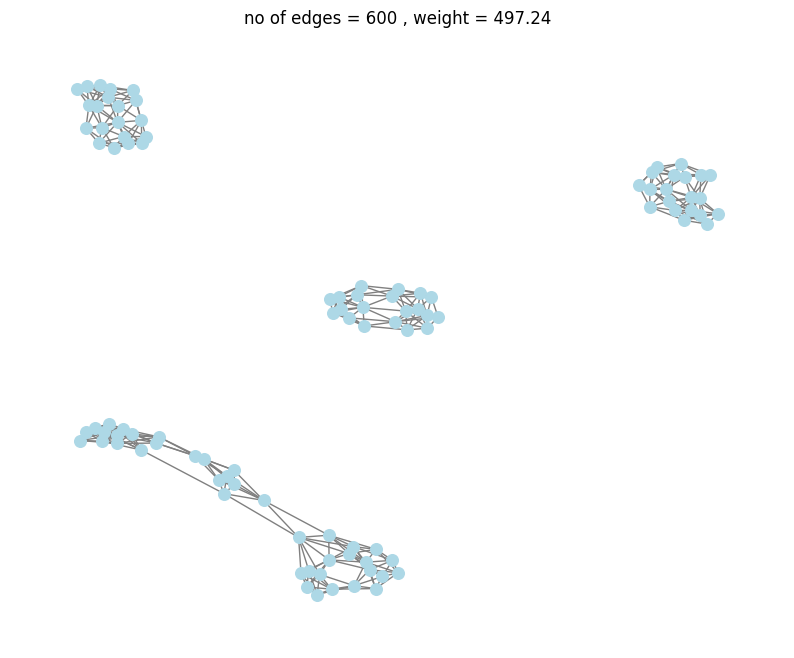

In [17]:
plot_graph(NN)

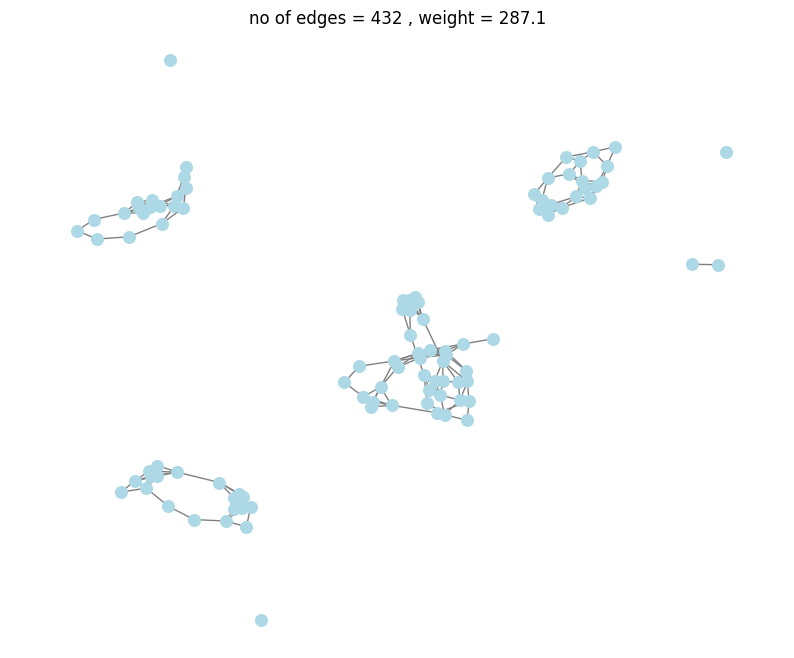

In [18]:
plot_graph(NaN)

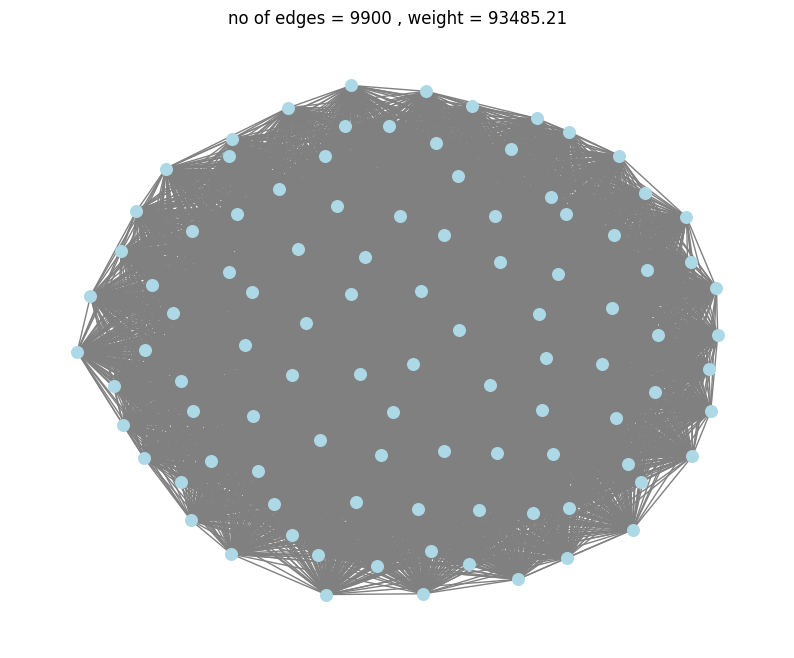

In [19]:
Complete = {pt : set(points) - set([pt]) for pt in points}
plot_graph(Complete)

In [20]:
def mst(graph , name):
    edges = []
    for src, neighbors in graph.items():
        for dest in neighbors:
            if (src, dest) not in edges and (dest, src) not in edges:
                edges.append((src, dest, distance(src, dest)))

    # Sort edges by weight
    edges.sort(key=lambda x: x[2])

    # Helper function to find set of an item (with path compression)
    def find(item, parent):
        if parent[item] == item:
            return item
        parent[item] = find(parent[item], parent)  # Path compression
        return parent[item]

    # Helper function to union two sets
    def union(set1, set2, parent, rank):
        root1 = find(set1, parent)
        root2 = find(set2, parent)

        if root1 != root2:
            if rank[root1] > rank[root2]:
                parent[root2] = root1
            else:
                parent[root1] = root2
                if rank[root1] == rank[root2]:
                    rank[root2] += 1

    # Kruskal's algorithm
    def kruskal(edges):
        mst = []
        parent = {v: v for v, _, _ in edges}
        rank = {v: 0 for v, _, _ in edges}

        for edge in edges:
            src, dest, weight = edge
            if find(src, parent) != find(dest, parent):
                mst.append(edge)
                union(src, dest, parent, rank)
        return mst

    # Get the Minimum Spanning Tree
    mst_edges = kruskal(edges)
    MST_G = nx.Graph()

# Add edges from the MST to the graph
    for edge in mst_edges:
        src, dest, _ = edge
        MST_G.add_edge(src, dest)

    # Calculate total number of edges in the MST
    total_edges = len(mst_edges)

    # Calculate total weight of the MST
    total_weight = sum(weight for _, _, weight in mst_edges)
    # Draw the MST
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(MST_G)
    nx.draw(MST_G, pos, with_labels=False, node_size=70, node_color="lightblue", edge_color="gray")
    plt.title(f"{name} MST no of edge = {total_edges} , total weight = {round(total_weight , 2)}")
    plt.show()

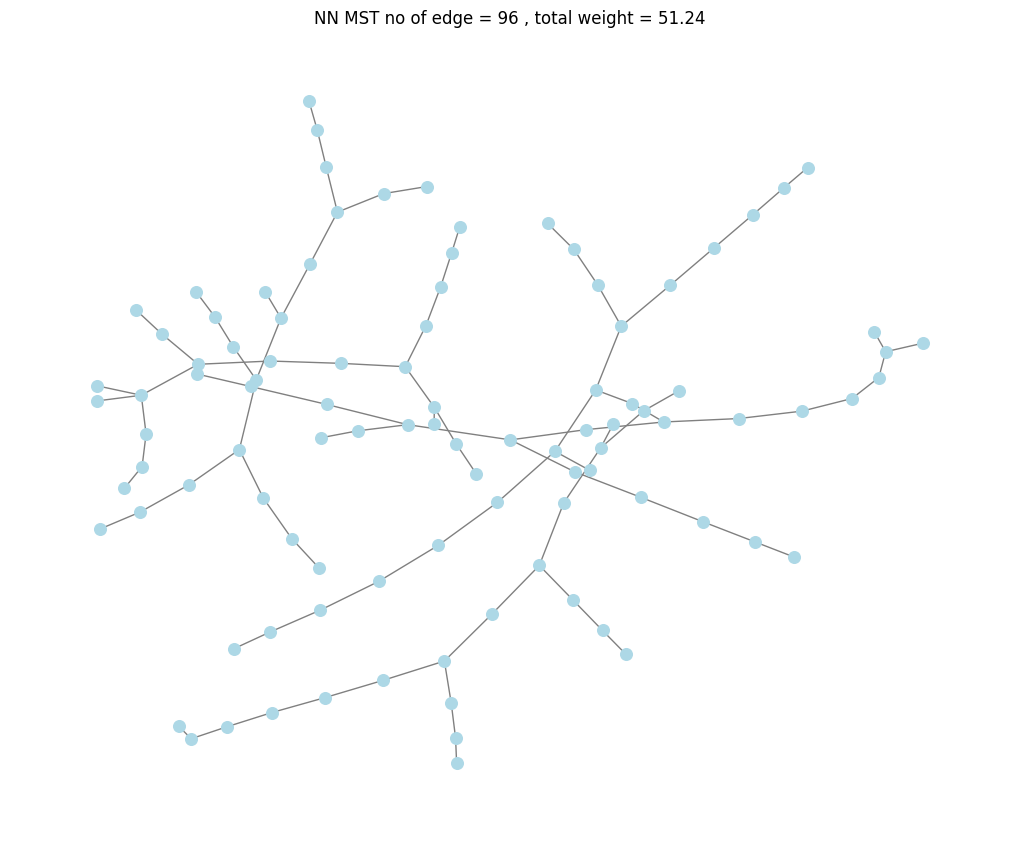

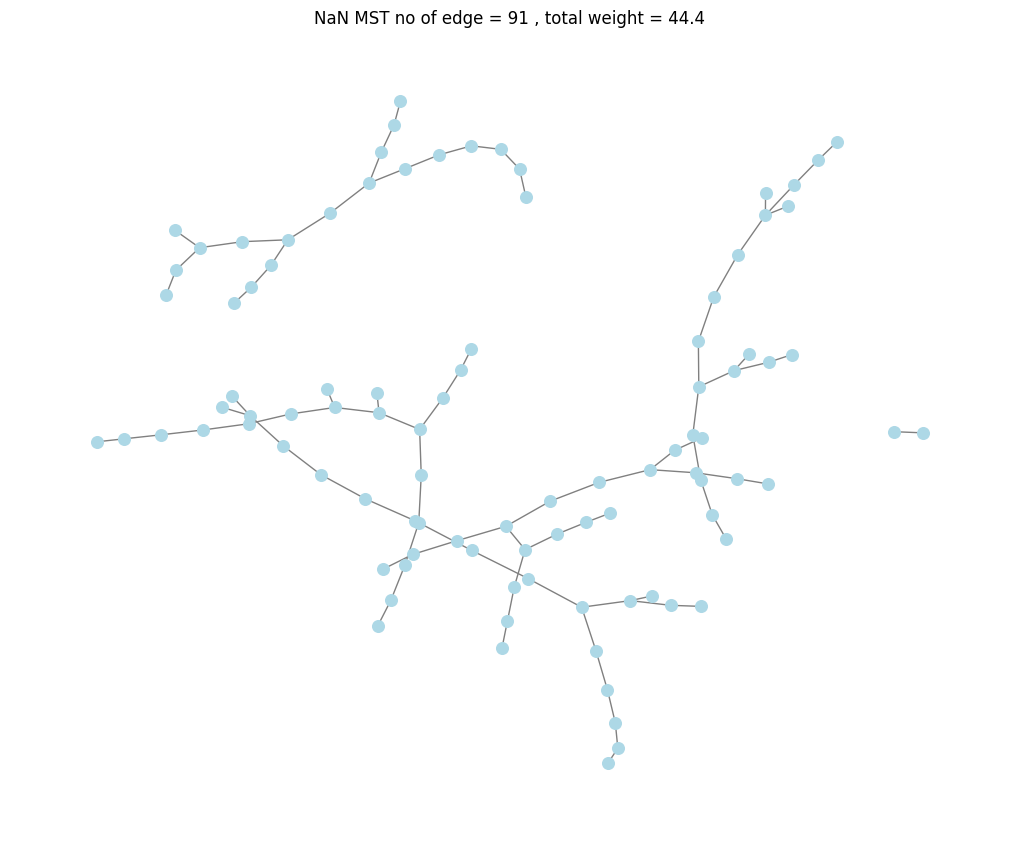

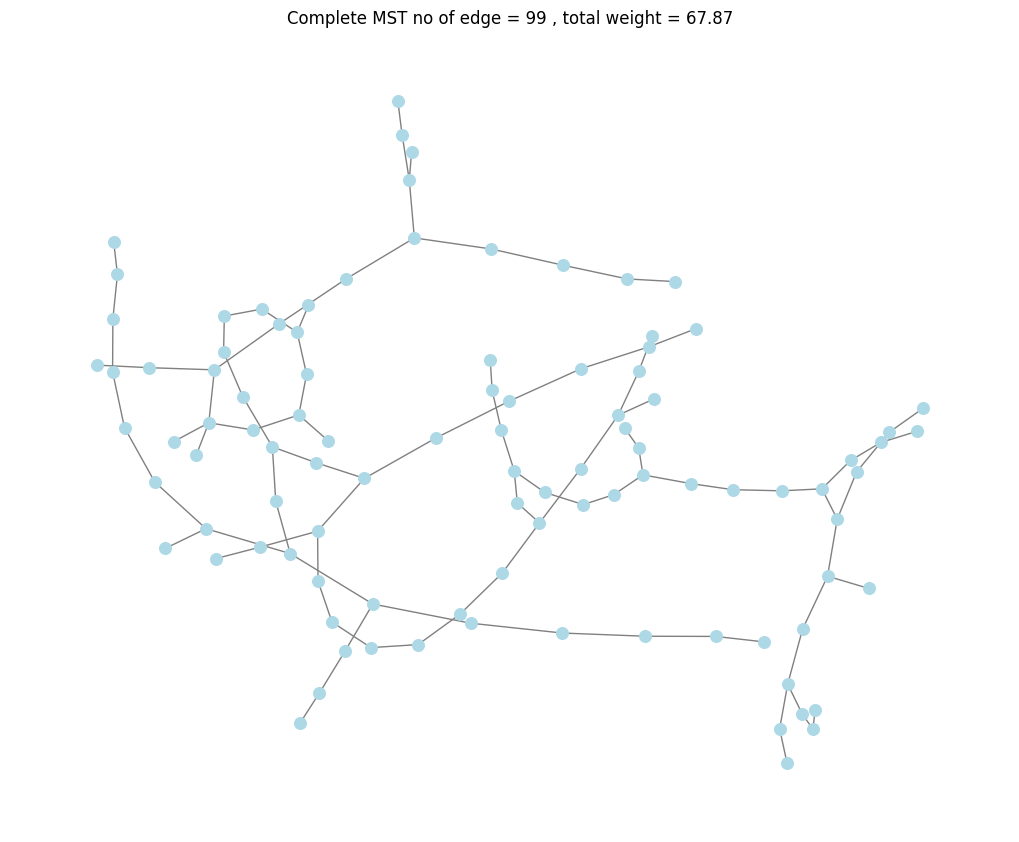

In [21]:
mst(NN , "NN")
mst(NaN , "NaN")
mst(Complete , "Complete")

In [22]:
# todo 2mst
# fast minimum distance to connect clusters

In [23]:
# ppt mst usefulness - data mining 
# time complexity of existing mst
# other approach